# Surrogate model construction 
$f_{all}(x) = f_{c}(x) + f_{p}(x,p)$

## 1. Library Reading

In [1]:
import pandas as pd
import numpy as np
np.random.seed(seed=1994)
from scipy.stats import norm

import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C, DotProduct
import warnings
warnings.simplefilter('ignore')

## 2. Parameter setting

In [2]:
# Unit definition
title_data = 'Ru3(CO)12 [RuCl2(CO)3]2 HRh(CO)(PPh3)3 Rh(acac)(CO)2 RhCl(CO)(PPh3)2 [bmim][Cl] [bmim][BF4]'.strip().split()
title_out = 'EXP-No. EXP-ID Ru3(CO)12 [RuCl2(CO)3]2 HRh(CO)(PPh3)3 Rh(acac)(CO)2 RhCl(CO)(PPh3)2 [bmim][Cl] [bmim][BF4]'.strip().split()
unit_gmol = np.array([639.33, 512.01, 918.80, 258.03, 690.94, 174.67, 226.03]) # g/mol
unit2mmol = np.array([0.09/3, 0.09/2,   0.09,   0.09,   0.09,    3.0/1.08,   3.0/1.21]) *0.01  # 0.09 mmol/metal, 0.01 is correction for % unit
unit2mg   = unit2mmol*unit_gmol # mg/metal

# Number of experimental data per round
n_total = 24
n_reference = 0
n_round = n_total - n_reference

# Reading Grid-data
grids = np.loadtxt('first_10.dat')

# Setting GPR parameter
alpha = 0 # because white kernel is used
aq_type = "EI" #
bbo_type = "kriging"

## 3. Experimental data Reading

In [3]:
experimental_id = ['Round-001', 'Round-002', 'Round-003', 'Round-004', 'Round-005', 'Round-006', 'Round-007']
date = 'Round7'
df_all = pd.read_csv("Results-DB_%s.csv"%(date), encoding="shift-jis")
df_all = df_all[df_all['PJ-ID'].isin(experimental_id)]

y_label = ['Ald_Yield']
x_label = [
    'Cat1.actual, mg', 'Cat2.actual, mg', 'Cat3.actual, mg',       
    'Cat4.actual, mg', 'Cat5.actual, mg', 'Ion1.actual, μL',
    'Ion2.actual, μL', 'CO2, MPa', 'H2, MPa'
]
x_data_all = df_all[x_label].to_numpy()
y_data_all = df_all[y_label].to_numpy()
a_data_all = df_all['EXP-ID']
ndata, ndim = x_data_all.shape if len(experimental_id)*24 == x_data_all.shape[0] else print('ERROR: amount of dataset')

x_data_all[:,:-2] = x_data_all[:,:-2]/unit2mg
x_data_all[:,:-2] = x_data_all[:,:-2]*100/np.sum(x_data_all[:,:-2],axis=1).reshape((ndata,1))
x_data_all[:,-2:] = x_data_all[:,-2:]*10.0

print("Ndata:", ndata,", Ndim:", ndim)

Ndata: 168 , Ndim: 9


## 4. Surrogate model Construction for composition data

In [4]:
composition_id = ['Round-001', 'Round-002', 'Round-003', 'Round-004', 'Round-005', 'Round-006']
df_1 = df_all[df_all['PJ-ID'].isin(composition_id)]
alpha = 0

x_label_1 = [
    'Cat1.actual, mg', 'Cat2.actual, mg', 'Cat3.actual, mg',
    'Cat4.actual, mg', 'Cat5.actual, mg', 'Ion1.actual, μL',
    'Ion2.actual, μL'
]
x_data_1 = df_1[x_label_1].to_numpy()
ndata_1, ndim_1 = x_data_1.shape

x_data_1 = x_data_1/unit2mg
x_data_1 = x_data_1*100/np.sum(x_data_1,axis=1).reshape((ndata_1,1))

y_data_1 = df_1[y_label].to_numpy()

kernel_1 = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=2.5)+ WhiteKernel(noise_level=1.0) +C()*DotProduct()
gp_1 = GaussianProcessRegressor(kernel=kernel_1, alpha=alpha, 
        optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20, 
        normalize_y=False, copy_X_train=True, random_state=1994)
gp_1.fit(x_data_1, y_data_1)
y_pred_1, y_std_1 = gp_1.predict(x_data_1, return_std=True)

## 5. Surrogate model Construction for Process & composition data

Kernel:  3.42**2 * Matern(length_scale=90.2, nu=2.5) + WhiteKernel(noise_level=0.407) + 0.00316**2 * DotProduct(sigma_0=9.69e-05)


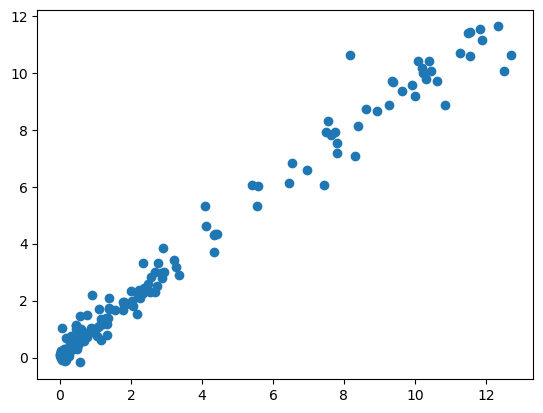

In [5]:
y_pred_1 = gp_1.predict(x_data_all[:,:-2]).flatten()
y_data_2 = y_data_all.flatten() - y_pred_1

kernel_2 = C()* Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=2.5)+ WhiteKernel(noise_level=1.0) +C()*DotProduct()
gp_2 = GaussianProcessRegressor(kernel=kernel_2, alpha=alpha, 
        optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20, 
        normalize_y=False, copy_X_train=True, random_state=1994)
gp_2.fit(x_data_all, y_data_2)
y_pred_2, y_std_2 = gp_2.predict(x_data_all, return_std=True)

plt.scatter( y_data_all.flatten(), y_pred_1+y_pred_2)
print('Kernel: ', gp_2.kernel_)